# Aux

In [ ]:
import numpy as np
import pennylane as qml 
import torch

def create_circuit(n_qubits,n_layers=None,circ = "simplified_two_design",fim=False, shots=None):

    dev = qml.device("default.qubit.torch", wires=n_qubits, shots=shots)

    def RZRY(params):
        #qml.SpecialUnitary(params, wires=range(n_qubits))
        #qml.SimplifiedTwoDesign(initial_layer_weights=init_params, weights=params, wires=range(n_qubits))
        #qml.AngleEmbedding(params,wires=range(n_qubits))
        for q in range(n_qubits):
            qml.Hadamard(wires=q)

        for w in range(n_layers): 
            for q in range(n_qubits):
                index = w * (2*n_qubits) + q * 2
                qml.RZ(params[index],wires=q)
                qml.RY(params[index + 1],wires=q)
        
        qml.broadcast(qml.CNOT , wires=range(n_qubits), pattern="all_to_all")
        
        return qml.probs(wires=range(n_qubits))

    def S2D(init_params,params,measurement_qubits=0,prod_approx=False):
        #qml.SpecialUnitary(params, wires=range(n_qubits))
        qml.SimplifiedTwoDesign(initial_layer_weights=init_params, weights=params, wires=range(n_qubits))
        
        #qml.broadcast(qml.CNOT , wires=range(n_qubits), pattern="all_to_all")
        if not prod_approx:
            return qml.probs(wires=list(range(measurement_qubits)))
        else:
            return [qml.probs(i) for i in range(measurement_qubits)]

    def SU(params):
        qml.SpecialUnitary(params, wires=range(n_qubits))
        
        ZZ = qml.operation.Tensor(qml.PauliZ(0), qml.PauliZ(1))
        for i in range(2,n_qubits):
            ZZ = qml.operation.Tensor(ZZ, qml.PauliZ(i))

        return qml.expval(ZZ)
    
    def simmpleRZRY(params,cnots=True):
        qml.broadcast(qml.Hadamard, wires=range(n_qubits), pattern="single")
        qml.broadcast(qml.RZ, wires=range(n_qubits), pattern="single", parameters=params[0])
        qml.broadcast(qml.RY, wires=range(n_qubits), pattern="single", parameters=params[1])
        if cnots:
            qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="chain")

            return qml.expval(qml.PauliZ(n_qubits-1))
        else:
            ZZ = qml.operation.Tensor(qml.PauliZ(0), qml.PauliZ(1))
            for i in range(2,n_qubits):
                ZZ = qml.operation.Tensor(ZZ, qml.PauliZ(i))

            return qml.expval(ZZ)
        
    def RY(params,y=True,probs=False,prod=False, entanglement=None):
        #qml.broadcast(qml.Hadamard, wires=range(n_qubits), pattern="single")
        qml.broadcast(qml.RY, wires=range(n_qubits), pattern="single", parameters=params)
        #qml.broadcast(qml.CZ, wires=range(n_qubits), pattern="all_to_all")

        if entanglement=="all_to_all":
            qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="all_to_all")
        
        if y==True:
            #YY = qml.operation.Tensor(qml.PauliY(0), qml.PauliY(1))
            YY = [qml.PauliZ(0), qml.PauliZ(1)]
            for i in range(2,n_qubits):
                #YY = qml.operation.Tensor(YY, qml.PauliY(i))
                YY.append(qml.PauliZ(i))
            
            #return [qml.expval(i) for i in YY]
            return qml.expval(YY)

        elif probs==False:

            ZZ = qml.operation.Tensor(qml.PauliZ(0), qml.PauliZ(1))
            #ZZ = [qml.PauliZ(0), qml.PauliZ(1)]
            for i in range(2,n_qubits):
                ZZ = qml.operation.Tensor(ZZ, qml.PauliZ(i))        
                #ZZ.append(qml.PauliZ(i))        

            #return [qml.expval(i) for i in ZZ]
            return qml.expval(ZZ)

        else:
            if prod:
                return [qml.probs(i) for i in range(n_qubits)]
            else:
                return qml.probs(wires=range(n_qubits))
            
        
        
    def GHZ(params,measurement_qubits=0):
        qml.RY(params,wires=0)
        qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="chain")

        return qml.probs(wires=range(measurement_qubits))

    def random_product_state(params,gate_sequence=None):
                
        for i in range(n_qubits):
            qml.RY(np.pi / 4, wires=i)

        for ll in range(len(params)):

            for i in range(n_qubits):
                gate_sequence["{}{}".format(ll,i)](params[ll][i], wires=i)

            #for i in range(n_qubits - 1):
                #qml.CZ(wires=[i, i + 1])
    def SEL(params, measurement_qubits=0):
        qml.StronglyEntanglingLayers(params, wires=range(n_qubits))
        return qml.probs(wires=range(measurement_qubits))
    
    def RL(params, measurement_qubits=0):
        qml.RandomLayers(params, ratio_imprim=0.8 ,imprimitive=qml.CZ, wires=range(n_qubits))
        return qml.probs(wires=range(measurement_qubits))
    
    if circ == "rzry":
        qcircuit = RZRY
    elif circ == "simplified_two_design":
        qcircuit = S2D
    elif circ == "special_unitary":
        qcircuit = SU
    elif circ == "simpleRZRY":
        qcircuit = simmpleRZRY
    elif circ == "RY":
        qcircuit = RY
    elif circ == "ghz":
        qcircuit = GHZ
    elif circ == "random_product_state":
        qcircuit = random_product_state
    elif circ == "SEL":
        qcircuit = SEL
    elif circ == "RL":
        qcircuit = RL
    if not fim:
        circuit = qml.QNode(qcircuit, dev,interface="torch", diff_method="backprop")
    else:
        circuit = qml.QNode(qcircuit, dev)

    return circuit

def compute_gradient(log_prob, w):
    """Compute gradient of the log probability with respect to weights.
    
    Args:
    - log_prob (torch.Tensor): The log probability tensor.
    - w (torch.Tensor): The weights tensor, with requires_grad=True.

    Returns:
    - numpy.ndarray: The gradient of log_prob with respect to w, flattened.
    """
    if w.grad is not None:
        w.grad.zero_()
    log_prob.backward(retain_graph=True)
    
    if w.grad is None:
        raise ValueError("The gradient for the given log_prob with respect to w is None.")
    
    return w.grad.view(-1).detach().numpy()

def policy(probs, policy_type="contiguous-like", n_actions=2, n_qubits=1):

    if policy_type == "contiguous-like":
        return probs
    elif policy_type == "parity-like":
        policy = torch.zeros(n_actions)
        for i in range(len(probs)):
            a=[]
            for m in range(int(np.log2(n_actions))):
                if m==0:    
                    bitstring = np.binary_repr(i,width=n_qubits)
                else:
                    bitstring = np.binary_repr(i,width=n_qubits)[:-m]
                
                a.append(bitstring.count("1") % 2)
            policy[int("".join(str(x) for x in a),2)] += probs[i]

        return policy    
    
def compute_policy_and_gradient(args):
    n_qubits, shapes, type , n_actions, policy_type, clamp = args

    if policy_type == "parity-like":
        measure_qubits = n_qubits
    else:
        measure_qubits = int(np.log2(n_actions))

    qc = create_circuit(n_qubits, circ=type, fim=False, shots=None)

    if type == "simplified_two_design":
        weights = [np.random.uniform(-np.pi,np.pi,size=shape) for shape in shapes]    
        weights_tensor_init = torch.tensor(weights[0], requires_grad=False)
        weights_tensor_params = torch.tensor(weights[1], requires_grad=True)
        
        probs = qc(weights_tensor_init,weights_tensor_params, measurement_qubits=measure_qubits)

    else:
        weights = [np.random.uniform(-np.pi,np.pi,size=shape) for shape in shapes]    
        weights_tensor_params = torch.tensor(weights, requires_grad=True)

        probs = qc(weights_tensor_params, measurement_qubits=measure_qubits)

    pi = policy(probs, policy_type=policy_type, n_actions=n_actions, n_qubits=n_qubits)
    if clamp is not None:
        pi = torch.clamp(pi, clamp, 1)

    dist = torch.distributions.Categorical(probs=pi)
    
    action = dist.sample()
    log_prob = dist.log_prob(action)

    gradient_no_clamp = np.linalg.norm(compute_gradient(log_prob, weights_tensor_params), 2)
    return gradient_no_clamp


In [ ]:
def reinforce(policy, optimizer, env, n_episodes=1000, max_t=1000, gamma=1.0, print_every=5):
    scores_deque = deque(maxlen=print_every)
    scores = []
    average_scores = []
    runtime_sum = 0
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            if t==0:
                state_tensor = torch.tensor(state[0]).float()
            else:
                state_tensor = torch.tensor(state).float()
            action, log_prob, _, = policy.sample(state_tensor)
            saved_log_probs.append(log_prob)
            state, reward, done, _, _ = env.step(action)
            rewards.append(reward)
            if done:
                break

    # Total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
    #standardized returns
        R=0
        policy_loss = []
        returns = []
        for r in rewards[::-1]:
            R = r + gamma * R
            returns.insert(0,R)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + np.finfo(np.float32).eps)

        for log_prob, R in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * R)

        policy_unsqueezed = [torch.unsqueeze(loss, 0) for loss in policy_loss]
        policy_sum = torch.cat(policy_unsqueezed).sum()

    # Backpropagation
        start_time = time.time()
        optimizer.zero_grad()
        policy_sum.backward()
        optimizer.step()
        end_time = time.time()
        runtime = end_time-start_time
        
        runtime_sum += runtime
        if e % print_every == 0:
            print('Episode {}\tLast reward: {:.2f}\tLast {}\tEpisodes average reward: {:.2f}\tRuntime: {:.2f}'.format(e, scores_deque[-1], print_every, np.mean(scores_deque), runtime_sum))
            runtime_sum = 0
        if np.mean(scores_deque) == 500:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
            break
    return scores, policy.gradient_list, average_scores  

# Policy Gradient Algorithm

In [3]:
import pennylane as qml
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym
from collections import deque

from joblib import Parallel, delayed
import os
import json
import time

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)

In [5]:
#utils
def measure_probs_basic(qubits):
    return qml.probs(wires=range(qubits)) 

def measure_expval_basic(qubits):
    return [
        qml.expval(qml.PauliZ(0) @ qml.PauliZ(1)),
        qml.expval(qml.PauliZ(2) @ qml.PauliZ(3))
    ]
    
def create_optimizer_with_lr(params, lr_list):
    optimizer = torch.optim.Adam([
        {'params': params, 'lr': lr} for params, lr in zip(params, lr_list)
    ])
    return optimizer

def jerbi_circuit(n_qubits, n_layers, shots, input_scaling, data_reuploading, diff_method, weight_init, input_init, measure, measure_qubits):

    if shots is None:
        dev = qml.device("default.qubit", wires=n_qubits)
    else:
        dev = qml.device("default.qubit", wires=n_qubits, shots=shots)
        
    if (data_reuploading and n_layers==0) or (not data_reuploading and n_layers>0):
        raise ValueError("Number of layers should be 0 if data_reuploading is False, and greater than 0 if data_reuploading is True.")
    
    if data_reuploading:
        weight_shapes = {"params": (n_layers + 1, n_qubits, 2),
                        "input_params": (n_layers, n_qubits, 2)}
        init_method   = {"params": weight_init,
                        "input_params": input_init}
    else:
        weight_shapes = {"params": (2, n_qubits, 2),
                        "input_params": (1, n_qubits, 2)}
        init_method   = {"params": weight_init,
                        "input_params": input_init}

    @qml.qnode(dev, interface='torch', diff_method=diff_method)
    def qnode(inputs, params, input_params):
        
    #in case n_qubits != input length
        if n_qubits > len(inputs) and n_qubits % len(inputs) == 0:
            multiplier = n_qubits // len(inputs)
            inputs = torch.cat([inputs] * multiplier)
        elif n_qubits != len(inputs) and n_qubits % len(inputs) != 0:
            raise ValueError('Number of qubits cannot be divided by input lenght')
            
    #hadamard
        qml.broadcast(qml.Hadamard, wires=range(n_qubits), pattern="single")
        
    #in case data_reuploading is True
        if data_reuploading:
        #iterate for each layer
            for layer in range(n_layers):
                for wire in range(n_qubits):
                    qml.RZ(params[layer][wire][0], wires=wire)
                    qml.RY(params[layer][wire][1], wires=wire)

                qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="chain")

            #in case input_scaling is True
                if input_scaling:
                    for wire in range(n_qubits):
                        qml.RY(input_params[layer][wire][0] * inputs[wire], wires=wire)
                        qml.RZ(input_params[layer][wire][1] * inputs[wire], wires=wire)
            #in case input_scaling is False
                else:
                    for wire in range(n_qubits):
                        qml.RY(inputs[wire], wires=wire)
                        qml.RZ(inputs[wire], wires=wire)

    #in case data_reuploading is False  
        else:
            for wire in range(n_qubits):
                qml.RZ(params[0][wire][0], wires=wire)
                qml.RY(params[0][wire][1], wires=wire)

            qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="chain")
            
        #in case input_scaling is True
            if input_scaling:
                for wire in range(n_qubits):
                    qml.RZ(input_params[-1][wire][0]* inputs[wire], wires=wire)
                    qml.RY(input_params[-1][wire][1]* inputs[wire], wires=wire)

        #in case input_scaling is False            
            else:
                for wire in range(n_qubits):
                    qml.RZ(input_params[-1][wire][0], wires=wire)
                    qml.RY(input_params[-1][wire][1], wires=wire)

    #last parameterized block
        for wire in range(n_qubits):
            qml.RZ(params[-1][wire][0], wires=wire)
            qml.RY(params[-1][wire][1], wires=wire)
        return measure(measure_qubits)

    model = qml.qnn.TorchLayer(qnode, weight_shapes=weight_shapes, init_method=init_method)  
    
    return model
    
def S2D(n_qubits, n_layers, shots, input_scaling, diff_method, weight_init, input_init, measure_type, observables, measure_qubits):

    dev = qml.device("default.qubit", wires=n_qubits)

    observables = observables if observables is not None else None
    
    shapes = qml.SimplifiedTwoDesign.shape(n_layers=n_layers, n_wires=n_qubits)

    weight_shapes = {"params": shapes[1],
                     "input_params": shapes[0]}
    
    init_method   = {"params": weight_init,
                     "input_params": input_init}

    @qml.qnode(dev, interface='torch', diff_method='parameter-shift')
    def qnode(inputs, params, input_params):

        return measure_selection(measure_type, observables, measure_qubits)

    model = qml.qnn.TorchLayer(qnode, weight_shapes=weight_shapes, init_method=init_method)

    return model

In [6]:
class CircuitGenerator(nn.Module):

    def __init__(self, n_qubits, n_layers,  shots= None, input_scaling=True, data_reuploading=True, design='jerbi_circuit', diff_method = 'backprop', weight_init=torch.nn.init.uniform_, input_init = torch.nn.init.ones_, measure = None, measure_qubits = None):
        super(CircuitGenerator, self).__init__()
        self.n_qubits = n_qubits                        #number of qubits
        self.n_layers = n_layers                        #number of layers
        self.shots = shots                              #number of shots
        self.input_scaling = input_scaling              #input scaling - True or False
        self.data_reuploading = data_reuploading        #data reuploading - True or False
        self.design = design                            #circuit design
        self.diff_method = diff_method                  #differentiator method                 
        self.weight_init = weight_init                  #weight initialization - torch.nn.init
        self.input_init = input_init                    #input weight initialization - torch.nn.init.
        if measure is None:
            self.measure = measure_probs_basic
        else:
            self.measure = measure

        if measure_qubits is None:
            self.measure_qubits = n_qubits
        else:
            self.measure_qubits = measure_qubits

        if self.design == 'jerbi_circuit':
            self.circuit = jerbi_circuit(n_qubits = self.n_qubits,
                                        n_layers = self.n_layers,
                                        shots = self.shots,
                                        input_scaling = self.input_scaling,
                                        data_reuploading = self.data_reuploading,
                                        diff_method = self.diff_method,
                                        weight_init = self.weight_init,
                                        input_init = self.input_init,
                                        measure = self.measure,
                                        measure_qubits = self.measure_qubits)
        else:
            raise ValueError("Unsupported circuit type")

    def input(self,inputs):

        outputs = self.circuit(inputs)
        return outputs

In [7]:
class PolicyType(nn.Module):
    
    def __init__(self, n_qubits, n_actions, post_processing = 'raw_contiguous'):
        self.n_actions = n_actions
        self.n_qubits = n_qubits
        self.post_processing = post_processing
        self.T = 1

    def input(self,probs):
        if self.post_processing == 'raw_contiguous':
            policy = self.raw_contiguous(probs)
        elif self.post_processing == 'raw_parity':
            policy = self.raw_parity(probs)
        elif self.post_processing == 'softmax':
            policy = self.softmax(probs)
        else:
            raise ValueError("Invalid post-processing method specified.")
        return policy

    def raw_contiguous(self,probs):

        probs_flatten = probs.flatten()
        chunk_size = len(probs_flatten) // self.n_actions
        remainder = len(probs_flatten) % self.n_actions

        policy = []

        for i in range(self.n_actions):
            start = i * chunk_size
            end = (i + 1) * chunk_size

            if i < remainder:
                end += 1

            # Update the original policy list instead of creating a new one
            policy.append(sum(probs_flatten[start:end]))

        policy_tensor = torch.stack(policy)
        return policy_tensor
    
    def raw_parity(self,probs):

        if self.n_actions % 2 != 0:
            raise ValueError('For parity-like policy, n_actions must be an even number')
        
        probs_flatten = probs.flatten()
        policy = torch.zeros(self.n_actions)
        counter = 0
        for prob in probs_flatten:
            policy[counter] += prob
            counter += 1
            if counter == self.n_actions:
                counter = 0
        
        policy_tensor = torch.stack(policy)

        return policy_tensor
    
    def softmax(self, probs):
        if len(probs) == self.n_actions:
            scaled_output = probs * self.T
            softmax_output = F.softmax(scaled_output, dim=0)
            return softmax_output
        else:
            probs_flatten = probs.flatten()
            chunk_size = len(probs_flatten) // self.n_actions
            remainder = len(probs_flatten) % self.n_actions

            policy = []

            for i in range(self.n_actions):
                start = i * chunk_size
                end = (i + 1) * chunk_size

                if i < remainder:
                    end += 1

                # Update the original policy list instead of creating a new one
                policy.append(sum(probs_flatten[start:end]))
            policy_tensor = torch.stack(policy)
            softmax_output = F.softmax(policy_tensor/self.T, dim=0)
            return softmax_output

In [8]:
class QuantumPolicyModel(nn.Module):
    
    def __init__(self, circuit, policy):
        super(QuantumPolicyModel, self).__init__()
        self.circuit = circuit
        self.policy = policy

    def forward(self, inputs):
        '''
        Input state is fed to the circuit - its output is then fed to the post processing 
        '''
        probs = self.circuit.input(inputs)
        probs_processed = self.policy.input(probs)
        return probs_processed
    
    def sample(self, inputs):
        '''
        Samples an action from the action probability distribution aka policy
        '''
        policy = self.forward(inputs)
        dist = torch.distributions.Categorical(policy)
        action = dist.sample()
        return action.item(), dist.log_prob(action), policy
    
    def T_schedule(self,current_step,total_steps):

        max_T = 1.0  # Initial temperature
        min_T = 0.1  # Final temperature
        decay_rate = 0.01  # Decay rate

        self.policy.T = max_T * (1 - decay_rate * current_step / total_steps)
        self.policy.T = max(self.policy.T, min_T)

    def get_parameters(self):
        '''
        Returns the values of each set of parameters
        '''
        parameter_values = [param.clone().detach().numpy().flatten() for param in self.circuit.parameters()]
        return parameter_values
    
    def get_gradients(self):
        '''
        Returns the gradient values of each set of parameters
        '''
        gradients = [torch.flatten(param.grad.clone().detach()) if param.grad is not None else torch.flatten(torch.zeros_like(param)) for name, param in self.circuit.named_parameters()]
        return gradients

In [9]:
class ReinforceUpdate():

    def __init__(self, pqc, optimizer, env, n_episodes, max_t, gamma, print_every, verbose, folder_path = None, file_name = None):
        
        self.pqc = pqc
        self.optimizer = optimizer
        self.env = env
        self.n_episodes = n_episodes
        self.max_t = max_t
        self.gamma = gamma
        self.scores_deque = deque(maxlen=print_every)
        self.runtime_deque = deque(maxlen=print_every)
        self.print_every = print_every
        self.verbose = verbose
        self.folder_path = folder_path
        self.file_name = file_name
        self.running_reward = 10

    def get_trajectory(self):

        self.saved_log_probs = []
        self.rewards = []
        state = self.env.reset()
        for t in range(self.max_t):
            # Sample the action from current policy
            if t == 0:
                state_tensor = torch.tensor(state[0]).float()
            else:
                state_tensor = torch.tensor(state).float()
            action, log_prob, _, = self.pqc.sample(state_tensor)
            self.saved_log_probs.append(log_prob)
            state, reward, done, _, _ = self.env.step(action)
            self.rewards.append(reward)
            if done:
                self.scores_deque.append(sum(self.rewards))
                break
    
    def update_policy_unstandard(self):

        R = 0
        policy_loss = []
        returns = []
        for r in self.rewards[::-1]:
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns)

        for log_prob, ret in zip(self.saved_log_probs, returns):
            policy_loss.append(-log_prob * ret)

        policy_unsqueezed = [torch.unsqueeze(loss, 0) for loss in policy_loss]
        self.loss = torch.cat(policy_unsqueezed).sum()

        self.optimizer.zero_grad()
        self.loss.backward()    
        self.optimizer.step()

    def update_policy_standard(self):

        R = 0
        policy_loss = []
        returns = []
        for r in self.rewards[::-1]:
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std())

        for log_prob, ret in zip(self.saved_log_probs, returns):
            policy_loss.append(-log_prob * ret)

        policy_unsqueezed = [torch.unsqueeze(loss, 0) for loss in policy_loss]
        self.loss = torch.cat(policy_unsqueezed).sum()

        self.optimizer.zero_grad()
        self.loss.backward()    
        self.optimizer.step()
        
    def save_episode_data(self):

        episode_data = {
                "episode_reward": self.scores_deque[-1],
                "episode_length": len(self.rewards),
                "runtime": self.runtime,
                "loss": self.loss.item(),
                "gradient": self.tensor_to_list(self.pqc.get_gradients()),
                "parameters": self.tensor_to_list(self.pqc.get_parameters())
        }

        if self.folder_path is not None:
            file_path = os.path.join(self.folder_path, f"{self.file_name}.json")
            if os.path.exists(file_path):
                with open(file_path, 'r') as f:
                    existing_data = json.load(f)
                existing_data.append(episode_data)
                with open(file_path, 'w') as f:
                    json.dump(existing_data, f, indent=4)
            else:
                with open(file_path, 'w') as f:
                    json.dump([episode_data], f, indent=4)

    def tensor_to_list(self, tensor):
        """
        Convert a tensor or numpy array to a nested list.
        """
        if isinstance(tensor, list):
            return [self.tensor_to_list(t) for t in tensor]
        elif isinstance(tensor, dict):
            return {key: self.tensor_to_list(value) for key, value in tensor.items()}
        elif isinstance(tensor, np.ndarray):
            return tensor.tolist()  # Convert numpy array to list
        elif isinstance(tensor, torch.Tensor):
            return tensor.tolist()  # Convert torch tensor to list
        else:
            return tensor
                    
    def train(self, data = 'standard'):

        runtime_sum=0
        for i in range(1, self.n_episodes):
            start_time = time.time()
            self.get_trajectory()
            self.pqc.T_schedule(i,self.n_episodes)
            if data == 'standard':
                self.update_policy_standard()
            elif data == 'unstandard':
                self.update_policy_unstandard()
            else:
                raise ValueError('data must take one of the following values: "standard","unstandard"')
            
            end_time = time.time()
            self.runtime = end_time - start_time
            self.save_episode_data()
            self.running_reward = (self.running_reward * 0.99) + (len(self.rewards) * 0.01)
            runtime_sum += self.runtime
            if self.running_reward > self.env.spec.reward_threshold:
                print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i, np.mean(self.scores_deque)))
                break
            elif i % self.print_every == 0 and self.verbose == 1:
                print('Episode {}\tLast reward: {:.2f}\tLast {} Episodes average reward: {:.2f}\tRuntime: {:.2f}\t {:.2f}\t'.format(i, self.scores_deque[-1], self.print_every, np.mean(self.scores_deque), runtime_sum, self.running_reward))
                runtime_sum=0

In [ ]:
class Analysis():
    

In [ ]:
n_qubits = 4
n_layers = 6      #set to 0 if data_reuploading = False
n_actions = 2
shots= None
input_scaling=False
data_reuploading=False
design='jerbi_circuit' 
diff_method = 'backprop' 
weight_init=torch.nn.init.uniform_
input_init = torch.nn.init.uniform_
circuit = CircuitGenerator(n_qubits, n_layers, measure= measure_expval_basic)

post_processing = 'softmax'
policy_type = PolicyType(n_qubits, n_actions, post_processing)


pqc = QuantumPolicyModel(circuit,policy_type)


pqc = pqc
lr_list= [0.01,0.1]
params= circuit.parameters()
optimizers= create_optimizer_with_lr(params,lr_list)
env_name = 'CartPole-v1'
env = gym.make(env_name)
n_episodes = 500
max_t = 500
gamma = 0.99
print_every = 5
verbose = 1
data = 'standard'

reinforce_update = ReinforceUpdate(pqc, optimizers, env, n_episodes, max_t, gamma, print_every, verbose)
reinforce_update.train(data)

In [14]:
# Parallel runs
current_directory = os.getcwd()

def train_agents(agent_id, pqc, optimizers, env, n_episodes, max_t, gamma, print_every, verbose, file_name, folder_path):

    reinforce_update = ReinforceUpdate(pqc, optimizers, env, n_episodes, max_t, gamma, print_every, verbose, folder_path, file_name)
    reinforce_update.train()

    return f"Agent {agent_id}: Training completed"

if __name__ == "__main__":
    n_qubits = 4
    n_layers = 4        #set to 0 if data_reuploading = False
    n_actions = 2
    shots= None
    input_scaling=True 
    data_reuploading=True
    design='jerbi_circuit' 
    diff_method = 'backprop' 
    weight_init=torch.nn.init.uniform_
    input_init = torch.nn.init.ones_
    measure_type = 'probs'
    observables = None
    measure_qubits = None
    circuit = CircuitGenerator(n_qubits, n_layers)


    #post_processing = 'softmax'
    policy_type = PolicyType(n_qubits, n_actions)


    pqc = QuantumPolicyModel(circuit,policy_type)
    

    pqc = pqc
    lr_list= [0.01,0.1]
    params= circuit.parameters()
    optimizers= create_optimizer_with_lr(params,lr_list)
    env_name = 'CartPole-v1'
    env = gym.make(env_name)
    n_episodes = 10
    max_t = 500
    gamma = 1
    print_every = 10
    verbose = 1
    
    folder_name = f"{env_name}_{policy_type.post_processing}_{circuit.n_layers}"
    folder_path = os.path.join(current_directory, folder_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    agent_variables = {
        "Number of Qubits": pqc.circuit.n_qubits,
        "Number of Layers": pqc.circuit.n_layers,
        "Shots": pqc.circuit.shots,
        "Input Scaling": pqc.circuit.input_scaling,
        "Data Re-uploading": pqc.circuit.data_reuploading,
        "Design": pqc.circuit.design,
        "Differentiation Method": pqc.circuit.diff_method,
        "Weight Initiation": str(pqc.circuit.weight_init),
        "Input_init": str(pqc.circuit.input_init),
        "Measure": str(pqc.circuit.measure),
        "Measure Qubits": pqc.circuit.measure_qubits,
        "Policy Type": pqc.policy.post_processing,
        "Optimizers": str(optimizers),
        "Envinronment Name": env_name,
        "Gamma (discounting factor)": gamma,
    }

    with open(os.path.join(folder_path, "agent_characteristics.json"), "w") as f:
        json.dump(agent_variables, f, indent=4)
        
    num_agents = 10

    results = Parallel(n_jobs=num_agents)(delayed(train_agents)(i, pqc, optimizers, env, n_episodes, max_t, gamma, print_every, verbose, i, folder_path) for i in range(num_agents))
    print(results)

['Agent 0: Training completed', 'Agent 1: Training completed', 'Agent 2: Training completed', 'Agent 3: Training completed', 'Agent 4: Training completed', 'Agent 5: Training completed', 'Agent 6: Training completed', 'Agent 7: Training completed', 'Agent 8: Training completed', 'Agent 9: Training completed']


In [ ]:
# Parallel runs
current_directory = os.getcwd()

def train_agents(agent_id, pqc, optimizers, env, n_episodes, max_t, gamma, print_every, verbose, file_name, folder_path):

    reinforce_update = ReinforceUpdate(pqc, optimizers, env, n_episodes, max_t, gamma, print_every, verbose, folder_path, file_name)
    reinforce_update.train()

    return f"Agent {agent_id}: Training completed"

if __name__ == "__main__":
    n_qubits = 4
    n_layers = 6        #set to 0 if data_reuploading = False
    n_actions = 2
    shots= None
    input_scaling=True 
    data_reuploading=True
    design='jerbi_circuit' 
    diff_method = 'backprop' 
    weight_init=torch.nn.init.uniform_
    input_init = torch.nn.init.ones_
    measure_type = 'probs'
    observables = None
    measure_qubits = None
    circuit = CircuitGenerator(n_qubits, n_layers)


    #post_processing = 'softmax'
    policy_type = PolicyType(n_qubits, n_actions)


    pqc = QuantumPolicyModel(circuit,policy_type)
    

    pqc = pqc
    lr_list= [0.01,0.1]
    params= circuit.parameters()
    optimizers= create_optimizer_with_lr(params,lr_list)
    env_name = 'CartPole-v1'
    env = gym.make(env_name)
    n_episodes = 10
    max_t = 500
    gamma = 1
    print_every = 10
    verbose = 1
    
    folder_name = f"{env_name}_{policy_type.post_processing}_{circuit.n_layers}"
    folder_path = os.path.join(current_directory, folder_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    agent_variables = {
        "Number of Qubits": pqc.circuit.n_qubits,
        "Number of Layers": pqc.circuit.n_layers,
        "Shots": pqc.circuit.shots,
        "Input Scaling": pqc.circuit.input_scaling,
        "Data Re-uploading": pqc.circuit.data_reuploading,
        "Design": pqc.circuit.design,
        "Differentiation Method": pqc.circuit.diff_method,
        "Weight Initiation": str(pqc.circuit.weight_init),
        "Input_init": str(pqc.circuit.input_init),
        "Measure": str(pqc.circuit.measure),
        "Measure Qubits": pqc.circuit.measure_qubits,
        "Policy Type": pqc.policy.post_processing,
        "Optimizers": str(optimizers),
        "Envinronment Name": env_name,
        "Gamma (discounting factor)": gamma,
    }

    with open(os.path.join(folder_path, "agent_characteristics.json"), "w") as f:
        json.dump(agent_variables, f, indent=4)
        
    num_agents = 10

    results = Parallel(n_jobs=num_agents)(delayed(train_agents)(i, pqc, optimizers, env, n_episodes, max_t, gamma, print_every, verbose, i, folder_path) for i in range(num_agents))
    print(results)

In [ ]:
# Parallel runs
current_directory = os.getcwd()

def train_agents(agent_id, pqc, optimizers, env, n_episodes, max_t, gamma, print_every, verbose, file_name, folder_path):

    reinforce_update = ReinforceUpdate(pqc, optimizers, env, n_episodes, max_t, gamma, print_every, verbose, folder_path, file_name)
    reinforce_update.train()

    return f"Agent {agent_id}: Training completed"

if __name__ == "__main__":
    n_qubits = 4
    n_layers = 8        #set to 0 if data_reuploading = False
    n_actions = 2
    shots= None
    input_scaling=True 
    data_reuploading=True
    design='jerbi_circuit' 
    diff_method = 'backprop' 
    weight_init=torch.nn.init.uniform_
    input_init = torch.nn.init.ones_
    measure_type = 'probs'
    observables = None
    measure_qubits = None
    circuit = CircuitGenerator(n_qubits, n_layers)


    #post_processing = 'softmax'
    policy_type = PolicyType(n_qubits, n_actions)


    pqc = QuantumPolicyModel(circuit,policy_type)
    

    pqc = pqc
    lr_list= [0.01,0.1]
    params= circuit.parameters()
    optimizers= create_optimizer_with_lr(params,lr_list)
    env_name = 'CartPole-v1'
    env = gym.make(env_name)
    n_episodes = 10
    max_t = 500
    gamma = 1
    print_every = 10
    verbose = 1
    
    folder_name = f"{env_name}_{policy_type.post_processing}_{circuit.n_layers}"
    folder_path = os.path.join(current_directory, folder_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    agent_variables = {
        "Number of Qubits": pqc.circuit.n_qubits,
        "Number of Layers": pqc.circuit.n_layers,
        "Shots": pqc.circuit.shots,
        "Input Scaling": pqc.circuit.input_scaling,
        "Data Re-uploading": pqc.circuit.data_reuploading,
        "Design": pqc.circuit.design,
        "Differentiation Method": pqc.circuit.diff_method,
        "Weight Initiation": str(pqc.circuit.weight_init),
        "Input_init": str(pqc.circuit.input_init),
        "Measure": str(pqc.circuit.measure),
        "Measure Qubits": pqc.circuit.measure_qubits,
        "Policy Type": pqc.policy.post_processing,
        "Optimizers": str(optimizers),
        "Envinronment Name": env_name,
        "Gamma (discounting factor)": gamma,
    }

    with open(os.path.join(folder_path, "agent_characteristics.json"), "w") as f:
        json.dump(agent_variables, f, indent=4)
        
    num_agents = 10

    results = Parallel(n_jobs=num_agents)(delayed(train_agents)(i, pqc, optimizers, env, n_episodes, max_t, gamma, print_every, verbose, i, folder_path) for i in range(num_agents))
    print(results)

Invalid JSON data in file agent_characteristics.json


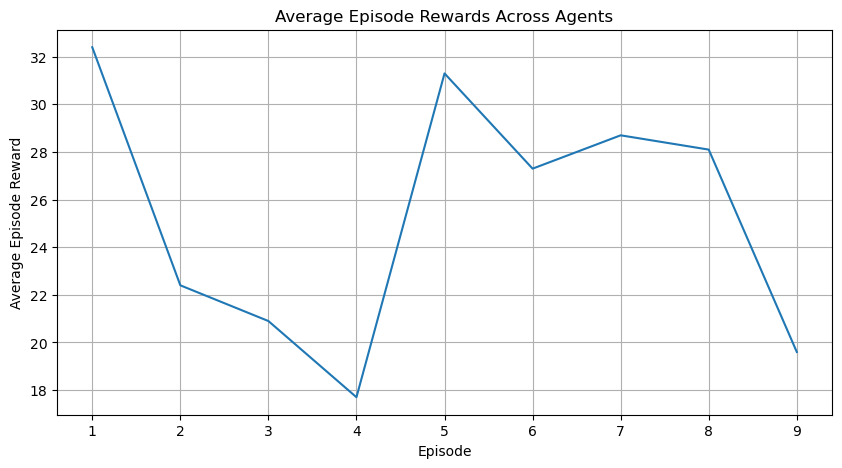

In [16]:
# Define the path to the folder containing JSON files
path = os.getcwd()
folder_name = 'CartPole-v1_raw_contiguous_4'
folder_path = os.path.join(path,folder_name)

json_files = [file for file in os.listdir(folder_path) if file.endswith('.json')]

# Initialize an empty list to store episode rewards from all agents
episode_rewards = []

# Iterate through each JSON file
for json_file in json_files:
    with open(os.path.join(folder_path, json_file), 'r') as f:
        # Load JSON data
        data = json.load(f)
        # Check if data is a list
        if isinstance(data, list):
            # Extract episode rewards for each agent
            agent_rewards = [agent["episode_reward"] for agent in data]
            # Add episode rewards to the list
            episode_rewards.append(agent_rewards)
        else:
            print(f"Invalid JSON data in file {json_file}")

# Calculate the average episode reward for each episode across agents
average_rewards = np.mean(np.array(episode_rewards), axis=0)
# Plot the average rewards
plt.plot(range(1, len(average_rewards) + 1), average_rewards, linestyle='-')
plt.xlabel('Episode')
plt.ylabel('Average Episode Reward')
plt.title('Average Episode Rewards Across Agents')
plt.grid(True)
plt.show()

In [ ]:
axs[1].fill_between(np.arange(len(skolik_datareup_acrobot_mean_return)), np.clip(skolik_datareup_acrobot_mean_return - skolik_datareup_acrobot_std_return,a_min=-500,a_max=0), np.clip(skolik_datareup_acrobot_mean_return + skolik_datareup_acrobot_std_return,a_min=-500,a_max=0), alpha=0.2, color="red")
axs[1].fill_between(np.arange(len(skolik_datareup_acrobot_mean_return)), np.clip(skolik_datareup_no_in_acrobot_mean_return - skolik_datareup_no_in_acrobot_std_return,a_min=-500,a_max=0), np.clip(skolik_datareup_no_in_acrobot_mean_return + skolik_datareup_no_in_acrobot_std_return,a_min=-500,a_max=0), alpha=0.2, color="green")
axs[1].fill_between(np.arange(len(skolik_datareup_acrobot_mean_return)), np.clip(skolik_datareup_no_out_acrobot_mean_return - skolik_datareup_no_out_acrobot_std_return,a_min=-500,a_max=0), np.clip(skolik_datareup_no_out_acrobot_mean_return + skolik_datareup_no_out_acrobot_std_return,a_min=-500,a_max=0), alpha=0.2, color="blue")
axs[1].fill_between(np.arange(len(skolik_datareup_acrobot_mean_return)), np.clip(skolik_datareup_no_in_out_acrobot_mean_return - skolik_datareup_no_in_out_acrobot_std_return,a_min=-500,a_max=0), np.clip(skolik_datareup_no_in_out_acrobot_mean_return + skolik_datareup_no_in_out_acrobot_std_return,a_min=-500,a_max=0), alpha=0.2, color="purple")


# Graph


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.title('Score per episode')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(average_scores)+1), average_scores)
plt.ylabel('Score')
plt.title('Average score of the previous 10 episodes')
plt.xlabel('Average of previous 10 #')
plt.show()

In [ ]:
param1_gradients = gradient_list[::2]
param2_gradients = gradient_list[1::2]

# Plotting gradients for parameters 1
plt.plot(param1_gradients, label='Parameters')
plt.xlabel('Episode')
plt.ylabel('Gradient Mean')
plt.title('Gradients of Parameters')
plt.legend()
plt.show()

# Plotting gradients for parameters 2
plt.plot(param2_gradients, label='Parameters')
plt.xlabel('Episode')
plt.ylabel('Gradient Mean')
plt.title('Gradients of Input Parameters')
plt.legend()
plt.show()

In [ ]:
cumulative_runtimes = np.cumsum([runtime / 60 for runtime in runtimes])

plt.plot(cumulative_runtimes)
plt.xlabel('Episodes')
plt.ylabel('Cumulative Runtime (Minutes)')
plt.title('Cumulative Runtimes')
plt.grid(True)
plt.show()

In [ ]:
import base64
import io
import os
import inspect
import gym
import glob
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML, display
import torch

def show_video_of_model(policy, env_name):
    current_dir = os.path.abspath('')
    video_dir = os.path.join(current_dir, 'video')
    os.makedirs(video_dir, exist_ok=True)  # Ensure video directory exists

    # Create the Gym environment with render mode
    env = gym.make(env_name, render_mode='rgb_array')
    video_path = os.path.join(video_dir, '{}.mp4'.format(env_name))
    vid = video_recorder.VideoRecorder(env, path=video_path)
    
    state = env.reset()
    done = False
    for t in range(1000):
        # Convert state to tensor if needed
        state_tensor = torch.tensor(state[0]).float() if t == 0 else torch.tensor(state).float()
        
        # Capture frame
        vid.capture_frame()
        
        # Sample action from policy
        action, log_prob, _, = policy.sample(state_tensor)
        
        # Take action in the environment
        next_state, reward, done, _, _ = env.step(action)
        state = next_state
        
        if done:
            break
    
    # Close video recorder and environment
    vid.close()
    env.close()
    
    print("Video saved at:", video_path)

def show_video(env_name):
    current_dir = os.path.abspath('')
    video_dir = os.path.join(current_dir, 'video')
    mp4list = glob.glob(os.path.join(video_dir, '*.mp4'))
    if len(mp4list) > 0:
        mp4 = os.path.join(video_dir, '{}.mp4'.format(env_name))
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

# Example usage
# show_video_of_model(pqc, 'CartPole-v1')
# show_video('CartPole-v1')

